# Image Classification

Have questions? Chat with us on Github or Slack:

[![Homepage](https://img.shields.io/badge/fugue-source--code-red?logo=github)](https://github.com/fugue-project/fugue)
[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](http://slack.fugue.ai)

When dealing with deep learning on image data, there are a couple of ways to involve distributed computing.

1. Preprocess and train images on a single machine. Predict on multiple machines with Spark/Dask/Ray
2. Preprocess images on multiple machines, train on a single machine, and then predict on multiple machines.
3. Preprocess and train on multiple machines, and then predict on multiple machines.

Fugue is most helpful for cases 1 and 2 where training happens on a single machine. This is because the model training requires specialized frameworks that support distributed training. Workers need to communicate with each other during the training process to update the weights. A framework that can help with this is [Horovod](https://github.com/horovod/horovod)

For the cases where we preprocess or predict on multiple machines with GPUs, we can just write the code for a single machine. Fugue will then be responsible for running that code on the Spark, Dask or Ray workers. This notebook is an example of scenario 1 where we train on a single machine, but then run the inference distributedly.

### Downloading Data

This will use the Kaggle Dataset about Shoe Classification. The data has been hosted publicly on S3 for download. This notebook is based off this [Kaggle notebook](https://www.kaggle.com/code/yiklunmong/pytorch-classifier-adidas-nike-converse/notebook).

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

import os
import zipfile

s3 = boto3.client('s3', region_name='us-east-2', config=Config(signature_version=UNSIGNED))

if not os.path.exists('/tmp/shoe-dataset.zip'):
    s3.download_file('fugue-demo', 'shoe-dataset.zip', '/tmp/shoe-dataset.zip')

with zipfile.ZipFile("/tmp/shoe-dataset.zip","r") as zip_ref:
    zip_ref.extractall("/tmp/processed/")
    
os.listdir("/tmp/processed")

['test', 'train']

### Imports

Some of these imports are not included in the default image for the tutorials because they would bloat the image size and slow down spin-up time. You may need to `pip` install them additionally.

In [2]:
import torch 
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.optim import lr_scheduler
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import datasets 

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import numpy as np
import glob

from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import random

### Viewing Data

In [3]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0] )
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    return img

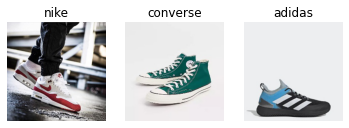

In [4]:
plt.figure()
plt.subplot(1,3,1)
steak_image = view_random_image("/tmp/processed/train/", "nike")
plt.subplot(1,3,2)
pizza_image = view_random_image("/tmp/processed/train/", "converse")
plt.subplot(1,3,3)
pizza_image = view_random_image("/tmp/processed/train/", "adidas")

### Training

This is where we train a model. We are not focused on the model performance. This is to make a model that we can use for distributed inference later.

In [5]:
# define paths
TRAIN_PATH = "/tmp/processed/train/"
TEST_PATH = "/tmp/processed/test/"

In [6]:
train_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
])

In [7]:
# function to split data set into training and validation sets
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [8]:
train_data = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
train_data = train_val_dataset(train_data)

Here we define a simple network that we will use for the model. No need to dive into the model specifics. That is not the focus of this tutorial.

In [9]:
class CNN(nn.Module):

    def __init__(self, out_1=16, out_2=16):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2, stride=1) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
        
        self.fc1 = nn.Linear(out_2 * 56 * 56,128)
        self.fc2 = nn.Linear(128, 3)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [10]:
# model configurations
model = CNN()
criterion = nn.CrossEntropyLoss()
lr = 0.01 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# create data loaders
train_loader = DataLoader(train_data['train'], batch_size=10, shuffle=True)
val_loader = DataLoader(train_data['val'], batch_size=10, shuffle=True)

This is the model training function. This is very standard deep learning code. None of this has anything to do with distributed inference yet.

In [11]:
train_cost_list = []
train_acc_list = []
val_cost_list = []
val_acc_list = []
N_train=len(train_data['train'])
N_val=len(train_data['val'])


def train_model(model, n_epochs):
    min_valid_loss = np.inf

    for epoch in tqdm(range(n_epochs)):
        print(f"Training epoch {epoch}...")
        TRAIN_COST = 0
        train_correct = 0
        for x, y in train_loader:
            if torch.cuda.is_available():
                x = x.to('cuda')
                y = y.to('cuda')
            optimizer.zero_grad() # gradient reset
            z = model(x) # run forward function in model
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            TRAIN_COST += loss.data # add loss of each BATCH into total loss of the epoch
            _, yhat = torch.max(z.data, 1)
            train_correct += (yhat == y).sum().item()
        train_cost_list.append(TRAIN_COST) # list of total loss of each epoch
        train_acc_list.append(train_correct / N_train)
        
        VAL_COST = 0
        val_correct = 0
        for x_val, y_val in val_loader:
            if torch.cuda.is_available():
                x_val = x_val.to('cuda')
                y_val = y_val.to('cuda')
            optimizer.zero_grad()
            z = model(x_val)
            loss = criterion(z, y_val)
            VAL_COST += loss.data
            _, yhat = torch.max(z.data, 1)
            val_correct += (yhat == y_val).sum().item()
        
        val_cost_list.append(VAL_COST)
        val_acc_list.append(val_correct / N_val)
        
        if min_valid_loss > VAL_COST:
            min_valid_loss = VAL_COST
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')

We just want the training to happen quickly here so we set the `n_epochs` to a low number.

In [12]:
n_epochs = 2

train_model(model, n_epochs)

  0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 0...


 50%|█████     | 1/2 [00:11<00:11, 11.73s/it]

Training epoch 1...


100%|██████████| 2/2 [00:21<00:00, 10.75s/it]


## Distributed Inference with Spark

In [13]:
TRAIN_PATH = "/tmp/processed/train/"
TEST_PATH = "/tmp/processed/test/"
label_mapping = datasets.ImageFolder(TRAIN_PATH).classes

In [14]:
import pandas as pd

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")
    
class ImageDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        image = pil_loader(self.paths[index])
        if self.transform is not None:
            image = self.transform(image)
        return image

This is the prediction logic for a batch

In [15]:
def predict_batch(df: pd.DataFrame) -> pd.DataFrame:
    model = CNN()
    model.load_state_dict(torch.load("saved_model.pth"))
    model.eval()
    
    transform = T.Compose([
        T.Resize(224),
        T.ToTensor(),
    ])

    images = ImageDataset(df['file_path'], transform=transform)
    loader = torch.utils.data.DataLoader(images, batch_size=16)

    all_predictions = []
    with torch.no_grad():
        for batch in loader:
            predictions = model(batch).cpu().numpy().argmax(1)
            for prediction in predictions:
                all_predictions.append(prediction)

    df["prediction"] = all_predictions
    df["prediction"] = df["prediction"].apply(lambda x: label_mapping[x])
    return df

We create a DataFrame of the images to predict. These are file paths that will be loaded in and predicted.

In [16]:
output_file_path = "/tmp/predictions"
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(TEST_PATH) for f in filenames if os.path.splitext(f)[1] == '.jpg']
df = pd.DataFrame({"file_path": files})
df.head()

,file_path
0,/tmp/processed/test/adidas/8.jpg
1,/tmp/processed/test/adidas/9.jpg
2,/tmp/processed/test/adidas/14.jpg
3,/tmp/processed/test/adidas/28.jpg
4,/tmp/processed/test/adidas/29.jpg


This is the code we need to bring the `predict_batch` function to Spark. This will apply the `predict_batch` on the partitions of the Spark DataFrame. This is the only part of the code that has anything to do with Spark.

For Dask and Ray, just pass the client to the engine and it will run on those backends.

In [18]:
from fugue import transform
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
transform(df, predict_batch, schema="*, prediction:str", engine=spark).show(5)

+--------------------+----------+
|           file_path|prediction|
+--------------------+----------+
|/tmp/processed/te...|      nike|
|/tmp/processed/te...|      nike|
|/tmp/processed/te...|      nike|
|/tmp/processed/te...|      nike|
|/tmp/processed/te...|      nike|
+--------------------+----------+
only showing top 5 rows

